In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random


Функция создания графа

In [2]:
def create_graph(graph, n, m):
    nodes = list(range(n))
    graph.add_nodes_from(nodes)
    edges = []
    if m > n*(n-1)/2:
        m = n*(n-1)/2
    while len(edges) != m:
        nodes1 = nodes.copy()
        n1 = random.choice(nodes1)
        nodes1.pop(n1)
        n2 = random.choice(nodes1)
        if (n1, n2) not in edges and (n2, n1) not in edges:
            edges.append((n1, n2))
    graph.add_edges_from(edges)


Функция нахождения эпицентров в графе

In [3]:
def detect_epicenters(curr_load, max_load):
    return [i for i in range(len(curr_load)) if curr_load[i] >= max_load[i]]


Функция отрисовки графа

In [4]:
def draw(graph, curr_load, max_load, i=0):
    epicenters = detect_epicenters(curr_load, max_load)
    if len(graph.nodes) > 0:
        plt.figure(i, figsize=(7, 7))
        pos = nx.circular_layout(graph)
        labels = {}
        pos_higher = {}
        for node in graph.nodes():
            labels[node] = round(curr_load[node], 2)
            pos_higher[node] = (pos[node][0], pos[node][1]+0.2)

        nx.draw(graph,
                pos,
                node_color='orange',
                node_size=800,
                with_labels=True)
        nx.draw_networkx_labels(graph,
                                pos_higher,
                                labels=labels,
                                bbox=dict(facecolor='white',
                                          edgecolor='Lavender', pad=5.0)
                                )
        if len(epicenters) > 0:
            nx.draw_networkx_nodes(graph,
                                   pos,
                                   nodelist=epicenters,
                                   node_size=500,
                                   alpha=0.7,
                                   linewidths=4,
                                   node_color="red")
        x_values, y_values = zip(*pos.values())
        y_max = max(y_values)
        y_min = min(y_values)
        y_margin = 0.5
        plt.ylim(y_min - y_margin, y_max + y_margin)


Критерии разрушения

In [5]:
def connection_criteria(graph):
    return nx.is_k_edge_connected(graph, k=1)

In [6]:
def no_full_destraction_criteria(graph):
    return len(graph.nodes) > 0

Получение диаметра графа

In [7]:
def get_diameter(graph):
    return nx.diameter(graph) if no_full_destraction_criteria(graph) else 0


Основная функция нагрузки системы

In [8]:
# k - количество эпицентров в начальный момент, draw_process - иллюстрировать процесс
def overload_system(graph, curr_load, max_load, k, draw_process=False):
    # создание эпиентров нагрузки
    epicenters = np.random.choice(range(n), k, replace=False)
    for epi in epicenters:
        curr_load[epi] = max_load[epi]
    i = 0   # количество итераций
    statistics = [{'time': i, 'diameter': get_diameter(graph), 'no_full_destraction': no_full_destraction_criteria(
        graph), 'connection': connection_criteria(graph)}]

    # проверка критериев отказа
    while len(epicenters) > 0 and no_full_destraction_criteria(graph):
        if draw_process:
            draw(graph, curr_load, max_load, i)
        epicenters = detect_epicenters(curr_load, max_load)
        i += 1
        for epi in epicenters:  # поиск связанных узлов для будущего распределение нагрузки
            connected_nodes = []
            for edge in graph.edges():
                if epi in edge:
                    connected_node = edge[1 - edge.index(epi)]
                    if curr_load[connected_node] != -1:
                        connected_nodes.append(connected_node)

            delta = curr_load[epi] / len(connected_nodes)
            curr_load[epi] = -1
            for ed in connected_nodes:  # распределение нагрузки
                curr_load[ed] += delta
        graph.remove_nodes_from(epicenters)
        connection_cr = connection_criteria(graph)
        # берем большую компоненту в качесте основного графа
        if no_full_destraction_criteria(graph):
            sorted_components = sorted(
                nx.connected_components(graph), key=len, reverse=True)
            graph = nx.Graph(graph.subgraph(sorted_components[0]))
            for ii in range(len(curr_load)):
                if ii not in graph.nodes:
                    curr_load[ii] = -1
        statistics.append({'time': i,
                           'diameter': get_diameter(graph),
                           'no_full_destraction': no_full_destraction_criteria(graph),
                           'connection': connection_cr})
    # возвращение статистики
    return statistics


In [19]:
n = 20   # количество вершин
m = 50   # количество рёбер
max_load = np.full(n, 10)  # максимальная загруженность
curr_load = np.random.randint(1, 8, size=(n)).astype(
    float)  # текущая загруженность
graph = nx.Graph()
# проверка на изначальную связанность
while not nx.is_k_edge_connected(graph, k=1):
    create_graph(graph, n, m)


Нагрузка 2-мя эпицентрами

<ipython-input-8-4346f5da17d1>:25: RuntimeWarning: divide by zero encountered in double_scalars
  delta = curr_load[epi] / len(connected_nodes)


[{'time': 0, 'diameter': 3, 'no_full_destraction': True, 'connection': True},
 {'time': 1, 'diameter': 4, 'no_full_destraction': True, 'connection': True},
 {'time': 2, 'diameter': 4, 'no_full_destraction': True, 'connection': True},
 {'time': 3, 'diameter': 4, 'no_full_destraction': True, 'connection': True},
 {'time': 4, 'diameter': 4, 'no_full_destraction': True, 'connection': True},
 {'time': 5, 'diameter': 4, 'no_full_destraction': True, 'connection': True},
 {'time': 6, 'diameter': 5, 'no_full_destraction': True, 'connection': False},
 {'time': 7, 'diameter': 3, 'no_full_destraction': True, 'connection': True},
 {'time': 8, 'diameter': 2, 'no_full_destraction': True, 'connection': False},
 {'time': 9, 'diameter': 0, 'no_full_destraction': True, 'connection': False},
 {'time': 10,
  'diameter': 0,
  'no_full_destraction': False,
  'connection': False}]

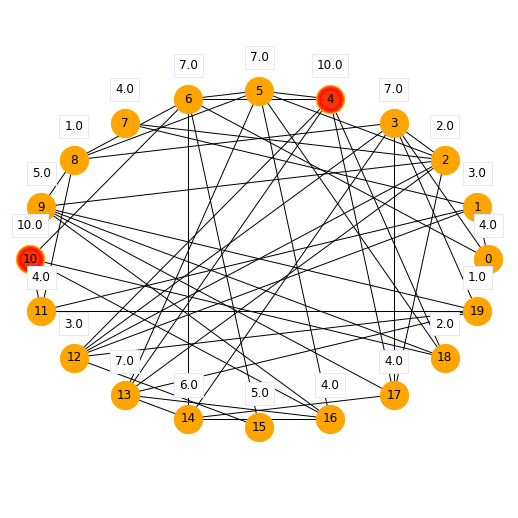

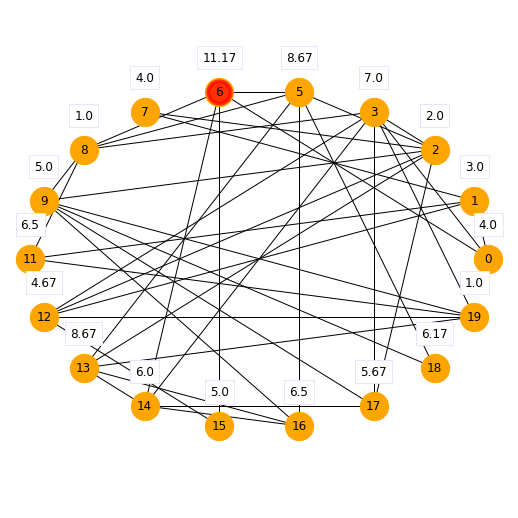

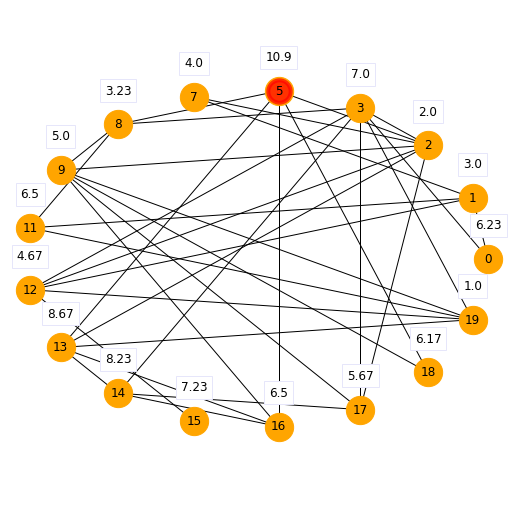

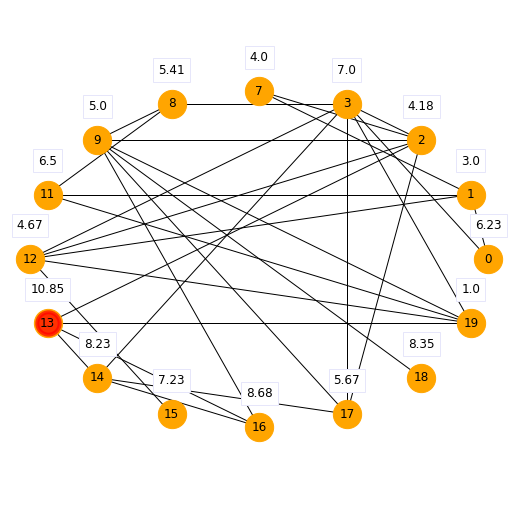

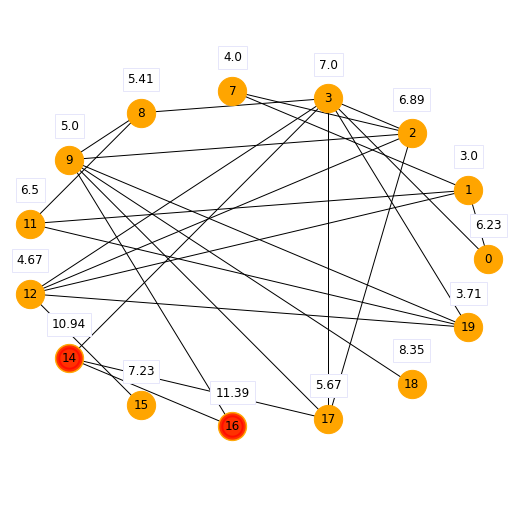

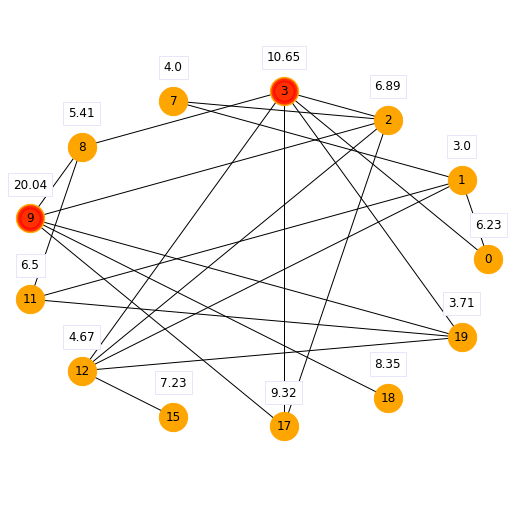

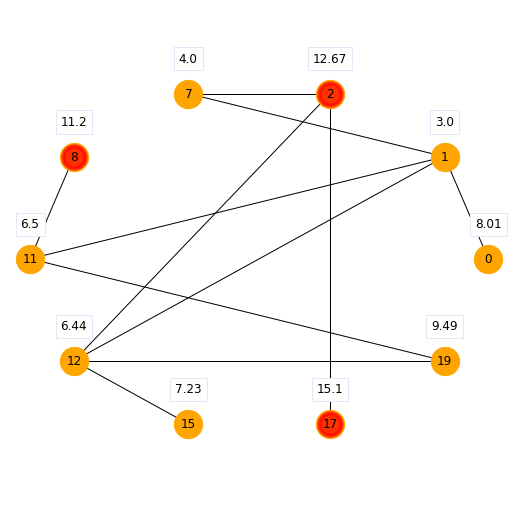

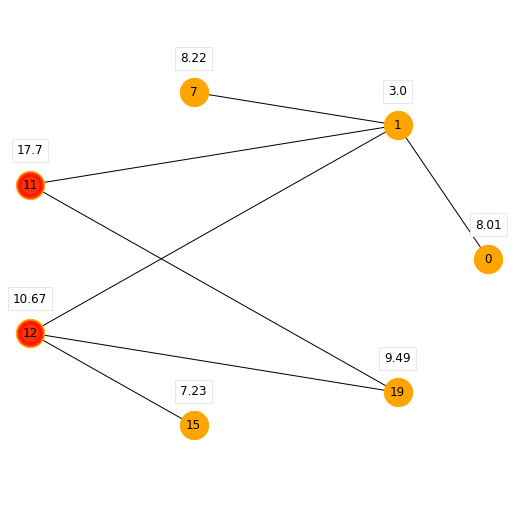

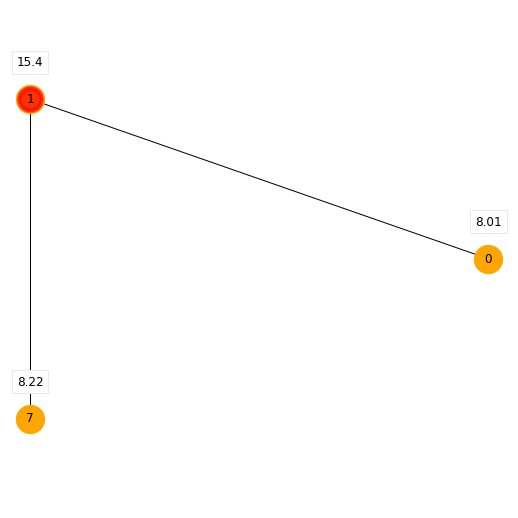

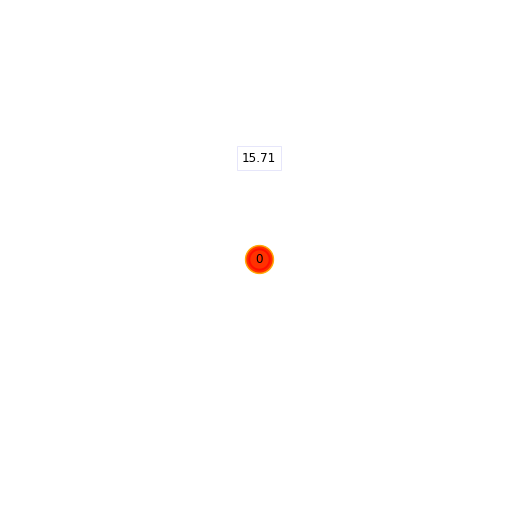

In [20]:
res = overload_system(graph, curr_load, max_load, 2, True)
res

Обработка статистики

In [21]:
points_y = []
points_x = []
destracted = []
notconnected = []
for line in res:
    points_x.append(line['time'])
    points_y.append(line['diameter'])
    if not line['no_full_destraction']:
        destracted.append(line['time'])
    if not line['connection']:
        notconnected.append(line['time'])
    

Визуализация статистики

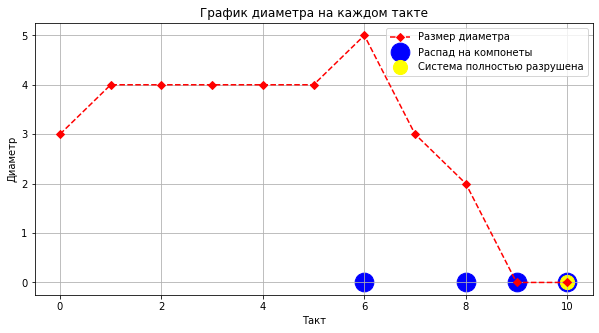

In [22]:
plt.figure(figsize=(10, 5))
plt.xlabel('Такт')
plt.ylabel('Диаметр')
plt.title('График диаметра на каждом такте')
plt.grid(True)
plt.plot(points_x, points_y, '--Dr', label='Размер диаметра')
plt.scatter(notconnected, len(notconnected)*[0], s=350, c='b', label='Распад на компонеты')
plt.scatter(destracted, len(destracted)*[0], s=200, c='yellow', label='Система полностью разрушена')
plt.legend(loc='best')

Данный граф при двух эпицентрах разрущается на 10 такте, при этом граф трижды распадался на компоненты и выбиралась большая для продолжения моделирования. Максимальный диаметр графа равен 5. 